## Bleu Score Evaluation + Graphs 

In [2]:
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/madelinepark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

In [4]:
# Create a new data structure with 3 columns 
# Questions from expert QA, revisde answer string from that question, model generated summary from the json from Jay 


import json

def parse_jsonl_for_fields(file_path, fields):
    """
    Parses a JSONL file and returns dictionaries for specified fields.

    :param file_path: Path to the JSONL file.
    :param fields: List of fields to extract data for.
    :return: A dictionary where each key is a field and the value is another dictionary
             of question-answer pairs for that field.
    """
    data = {field: {} for field in fields}
    
    with open(file_path, 'r') as file:
        for line in file:
            line_data = json.loads(line)
            field = line_data.get('metadata', {}).get('field')
            question = line_data.get('question')

            for answer_key in line_data.get('answers', {}):
                revised_answer = line_data['answers'][answer_key].get('revised_answer_string')
                if field in fields and question and revised_answer:
                    data[field][question] = revised_answer
                    break # There is only one revised answer per question

            if field in fields and question and revised_answer:
                data[field][question] = revised_answer

    return data

fields_of_interest = ["Healthcare / Medicine", "Law"]
parsed_data = parse_jsonl_for_fields('expertqa.jsonl', fields_of_interest)



In [7]:
print(parsed_data.keys())
medicine_parsed_data = parsed_data['Healthcare / Medicine']


dict_keys(['Healthcare / Medicine', 'Law'])


#### Medchatbot

In [9]:
import json

# Read the entire file into a single string
with open('medical_chatbot.json', 'r') as file:
    data = file.read()

# Assuming that each object is properly closed, you can use a simple regex to split them
import re
objects = re.split(r'(?<=})', data)[:-1]  # Split and remove the last empty string

# Parse each JSON object and collect into a list
parsed_data = [json.loads(obj) for obj in objects if obj.strip()]
# parsed_data
combined_dict = {}

# Loop through each dictionary in the list
for dict_item in parsed_data:
    for question, answer in dict_item.items():
        combined_dict[question] = answer

# Now `combined_dict` contains all questions as keys and answers as values
# print(combined_dict)

In [15]:
# SCALING WITH CHENCHERRY 

import nltk
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from nltk.tokenize import word_tokenize

# Ensure you have the necessary resources
nltk.download('punkt')

# Initialize the smoothing function
chencherry = SmoothingFunction()

metric_results = {}
for question in combined_dict.keys():
    # Tokenize the reference and candidate texts
    ref_tokens = word_tokenize(combined_dict[question])
    cand_tokens = word_tokenize(medicine_parsed_data[question])
    
    # Calculate the BLEU score using a smoothing function
    score = sentence_bleu([ref_tokens], cand_tokens, smoothing_function=chencherry.method1)
    
    # Store the result
    metric_results[question] = score

len(metric_results)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/madelinepark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


504

In [16]:
# MAKE A CSV 
filename = 'smoothed_bleu_score_medicalchatbot.csv'
# Writing to CSV
import csv
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Question', 'Smooth_Bleu_Score'])  # Writing header
    for key, value in metric_results.items():
        writer.writerow([key, value])

#### Biomstrl

In [18]:
# Biomstrl code 

import json

# Read the entire file into a single string
with open('biomistral.json', 'r') as file:
    data = file.read()

# Assuming that each object is properly closed, you can use a simple regex to split them
import re
objects = re.split(r'(?<=})', data)[:-1]  # Split and remove the last empty string

# Parse each JSON object and collect into a list
parsed_data = [json.loads(obj) for obj in objects if obj.strip()]
# parsed_data
combined_dict = {}

# Loop through each dictionary in the list
for dict_item in parsed_data:
    for question, answer in dict_item.items():
        combined_dict[question] = answer


chencherry = SmoothingFunction()

biomstrl_metric_results = {}
for question in combined_dict.keys():
    # Tokenize the reference and candidate texts
    ref_tokens = word_tokenize(combined_dict[question])
    cand_tokens = word_tokenize(medicine_parsed_data[question])
    
    # Calculate the BLEU score using a smoothing function
    score = sentence_bleu([ref_tokens], cand_tokens, smoothing_function=chencherry.method1)
    
    # Store the result
    biomstrl_metric_results[question] = score

len(biomstrl_metric_results)


504

In [19]:
# Writing to CSV
import csv

filename = 'smoothed_bleu_score_biomstrl.csv'

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Question', 'Smooth_Bleu_Score'])  # Writing header
    for key, value in biomstrl_metric_results.items():
        writer.writerow([key, value])


### Read in CSVS and make graphs 

In [20]:
biomstrl = pd.read_csv('smoothed_bleu_score_biomstrl.csv')
medchatbot = pd.read_csv('smoothed_bleu_score_medicalchatbot.csv')


In [21]:
biomstrl.head()

,Question,Smooth_Bleu_Score
0,What are signs and study findings that would i...,0.090495
1,A patient with a history of heart failure now ...,0.093564
2,What does research currently say regarding the...,0.069141
3,A patient with Ewing sarcoma of the femur is d...,0.051950
4,In which cases would be considered appropiate ...,0.018382


In [22]:
medchatbot.head()

,Question,Smooth_Bleu_Score
0,What are signs and study findings that would i...,0.039175
1,A patient with a history of heart failure now ...,0.083652
2,What does research currently say regarding the...,0.062602
3,A patient with Ewing sarcoma of the femur is d...,0.053922
4,In which cases would be considered appropiate ...,0.019201


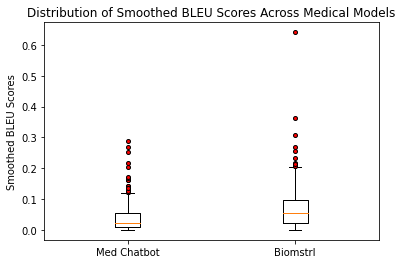

In [23]:
import matplotlib.pyplot as plt

# Example data: Replace these lists with your actual BLEU scores
bleu_scores_model_1 = medchatbot['Smooth_Bleu_Score']
bleu_scores_model_2 = biomstrl['Smooth_Bleu_Score']

data = [bleu_scores_model_1, bleu_scores_model_2]
plt.boxplot(data, labels=['Med Chatbot', 'Biomstrl'],flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'red'})
plt.ylabel('Smoothed BLEU Scores')
plt.title('Distribution of Smoothed BLEU Scores Across Medical Models')
plt.show()

### Adding question type to original csv and results 

In [24]:
def read_jsonl(filepath, limit=None, verbose=False):
    """Read jsonl file to a List of Dicts."""
    data = []
    with open(filepath, "r") as jsonl_file:
      for idx, line in enumerate(jsonl_file):
          if limit is not None and idx >= limit:
              break
          if verbose and idx % 100 == 0:
              # Print the index every 100 lines.
              print("Processing line %s." % idx)
          try:
              data.append(json.loads(line))
          except json.JSONDecodeError as e:
              print("Failed to parse line: `%s`" % line)
              raise e
    print("Loaded %s lines from %s." % (len(data), filepath))
    return data

In [25]:
r2_compiled_data=read_jsonl("r2_compiled_anon.jsonl")

Loaded 2177 lines from r2_compiled_anon.jsonl.


In [26]:
r2_compiled_data[0]['metadata']

{'question_type': 'Directed question that has a single unambiguous answer',
 'field': 'Healthcare / Medicine',
 'specific_field': 'Oncology'}

In [27]:
flattened_data = []
count=0
for item in r2_compiled_data:
    question = item['question']
    annotator_id = item['annotator_id']
    question_type = item['metadata']['question_type']
    specific_field = item['metadata']['specific_field']
    # Split the question_type by '|' to create a list of question types
    question_types = question_type.split('|')
    question_types = [q_type.strip() for q_type in question_types]  # Strip any extra spaces
    if len(question_types)>1:
        count+=1

    # Can add whatever additional data/metadata fields you want 
    for answer_key, answer_value in item['answers'].items():
        answer_string = answer_value['answer_string']
        attribution = ", ".join(answer_value['attribution'])  # Convert list to string
        claims = "; ".join(claim['claim_string'] for claim in answer_value['claims'])  # Join all claims into one string
        flattened_data.append({
            'question': question,
            'annotator_id': annotator_id,
            'answer_key': answer_key,
            'answer_string': answer_string,
            'attribution': attribution,
            'claims': claims,
            'question_types':question_types,
            'specific_field': specific_field           
            
        })

# Creating DataFrame
full_df = pd.DataFrame(flattened_data)

In [28]:
print(full_df.columns)
full_df.head()

Index(['question', 'annotator_id', 'answer_key', 'answer_string',
       'attribution', 'claims', 'question_types', 'specific_field'],
      dtype='object')


,question,annotator_id,answer_key,answer_string,attribution,claims,question_types,specific_field
0,What are signs and study findings that would i...,1,rr_gs_gpt4,Signs that might indicate a transformation of ...,[1] https://lymphoma.org/news/ask-the-doctor-h...,Signs that might indicate a transformation of ...,[Directed question that has a single unambiguo...,Oncology
1,A patient with a history of heart failure now ...,1,bing_chat,"😊\n\nAccording to the web search results, the...",[1] https://www.webmd.com/breast-cancer/featur...,"😊 According to the web search results, the re...",[Advice or suggestions on how to approach a pr...,Oncology
2,What does research currently say regarding the...,1,post_hoc_gs_gpt4,"Research currently indicates that cryotherapy,...",[1] https://www.oncnursingnews.com/view/frozen...,"Research currently indicates that cryotherapy,...",[Summarization of information on a topic],Oncology
3,A patient with Ewing sarcoma of the femur is d...,1,post_hoc_gs_gpt4,In the case of a patient with Ewing sarcoma of...,"[1] https://www.mdpi.com/2077-0383/9/8/2549, [...",In the case of a patient with Ewing sarcoma of...,[Directed question that has a single unambiguo...,Oncology
4,What will the impact of AI-generated musical p...,2,rr_gs_gpt4,The impact of AI-generated musical products on...,[1] https://cointelegraph.com/news/the-rise-of...,The impact of AI-generated musical products on...,[Open-ended question that is potentially ambig...,Recording and producing artist


In [29]:
# Read in results csvs and append a column for the types 
biomstrl = pd.read_csv('smoothed_bleu_score_biomstrl.csv')
medchatbot = pd.read_csv('smoothed_bleu_score_medicalchatbot.csv')
new_columns = ['question', 'Smooth_Bleu_Score']

# Assign new column names
biomstrl.columns = new_columns
medchatbot.columns = new_columns

In [30]:
biomstrl_with_qtype = pd.merge(biomstrl, full_df, on='question', how='left')
biomstrl_with_qtype=biomstrl_with_qtype.drop(columns=['annotator_id','answer_key','answer_string','attribution','claims'])


medchatbot_with_qtype = pd.merge(medchatbot, full_df, on='question', how='left')
medchatbot_with_qtype=medchatbot_with_qtype.drop(columns=['annotator_id','answer_key','answer_string','attribution','claims'])


In [31]:
biomstrl_with_qtype.head()


,question,Smooth_Bleu_Score,question_types,specific_field
0,What are signs and study findings that would i...,0.090495,[Directed question that has a single unambiguo...,Oncology
1,A patient with a history of heart failure now ...,0.093564,[Advice or suggestions on how to approach a pr...,Oncology
2,What does research currently say regarding the...,0.069141,[Summarization of information on a topic],Oncology
3,A patient with Ewing sarcoma of the femur is d...,0.051950,[Directed question that has a single unambiguo...,Oncology
4,In which cases would be considered appropiate ...,0.018382,[Open-ended question that is potentially ambig...,General Physician


In [32]:
medchatbot_with_qtype.head()

,question,Smooth_Bleu_Score,question_types,specific_field
0,What are signs and study findings that would i...,0.039175,[Directed question that has a single unambiguo...,Oncology
1,A patient with a history of heart failure now ...,0.083652,[Advice or suggestions on how to approach a pr...,Oncology
2,What does research currently say regarding the...,0.062602,[Summarization of information on a topic],Oncology
3,A patient with Ewing sarcoma of the femur is d...,0.053922,[Directed question that has a single unambiguo...,Oncology
4,In which cases would be considered appropiate ...,0.019201,[Open-ended question that is potentially ambig...,General Physician


In [33]:
# DOWNLOAD CSVS WITH THE FIELD AND QUESTION TYPES 
biomstrl_with_qtype.to_csv('biomstrl_with_qtype_field_smoothed_scores.csv', index=False)

medchatbot_with_qtype.to_csv('medchatbot_with_qtype_field_smoothed_scores.csv', index=False)

### Make graphs for question type and field 

In [42]:
# Make graphs 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [47]:
print(type(biomstrl_with_qtype['question_types'].iloc[0]))
biomstrl_with_qtype_exploded_df = biomstrl_with_qtype.explode('question_types')
print(biomstrl_with_qtype_exploded_df.head())
len(biomstrl_with_qtype_exploded_df)

<class 'list'>
                                            question  Smooth_Bleu_Score  \
0  What are signs and study findings that would i...           0.090495   
1  A patient with a history of heart failure now ...           0.093564   
1  A patient with a history of heart failure now ...           0.093564   
1  A patient with a history of heart failure now ...           0.093564   
2  What does research currently say regarding the...           0.069141   

                                      question_types specific_field  
0  Directed question that has a single unambiguou...       Oncology  
1  Advice or suggestions on how to approach a pro...       Oncology  
1  Question that describes a hypothetical scenari...       Oncology  
1                     Request for opinion on a topic       Oncology  
2            Summarization of information on a topic       Oncology  


682

In [49]:
print(type(medchatbot_with_qtype['question_types'].iloc[0]))
medchatbot_with_qtype_exploded_df = medchatbot_with_qtype.explode('question_types')
print(medchatbot_with_qtype_exploded_df.head())
len(medchatbot_with_qtype_exploded_df)

<class 'list'>
                                            question  Smooth_Bleu_Score  \
0  What are signs and study findings that would i...           0.039175   
1  A patient with a history of heart failure now ...           0.083652   
1  A patient with a history of heart failure now ...           0.083652   
1  A patient with a history of heart failure now ...           0.083652   
2  What does research currently say regarding the...           0.062602   

                                      question_types specific_field  
0  Directed question that has a single unambiguou...       Oncology  
1  Advice or suggestions on how to approach a pro...       Oncology  
1  Question that describes a hypothetical scenari...       Oncology  
1                     Request for opinion on a topic       Oncology  
2            Summarization of information on a topic       Oncology  


682

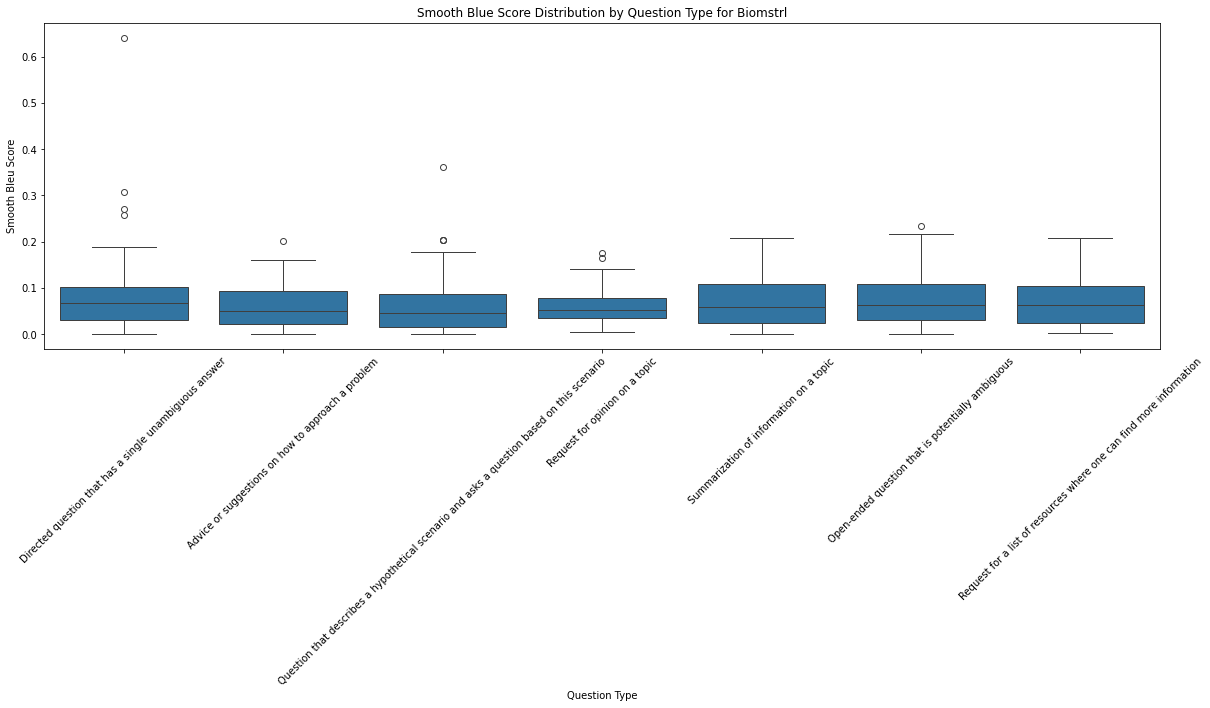

In [52]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='question_types', y='Smooth_Bleu_Score', data=biomstrl_with_qtype_exploded_df)
plt.title('Smooth Blue Score Distribution by Question Type for Biomstrl')
plt.xlabel('Question Type')
plt.ylabel('Smooth Bleu Score')
plt.xticks(rotation=45)
plt.show()

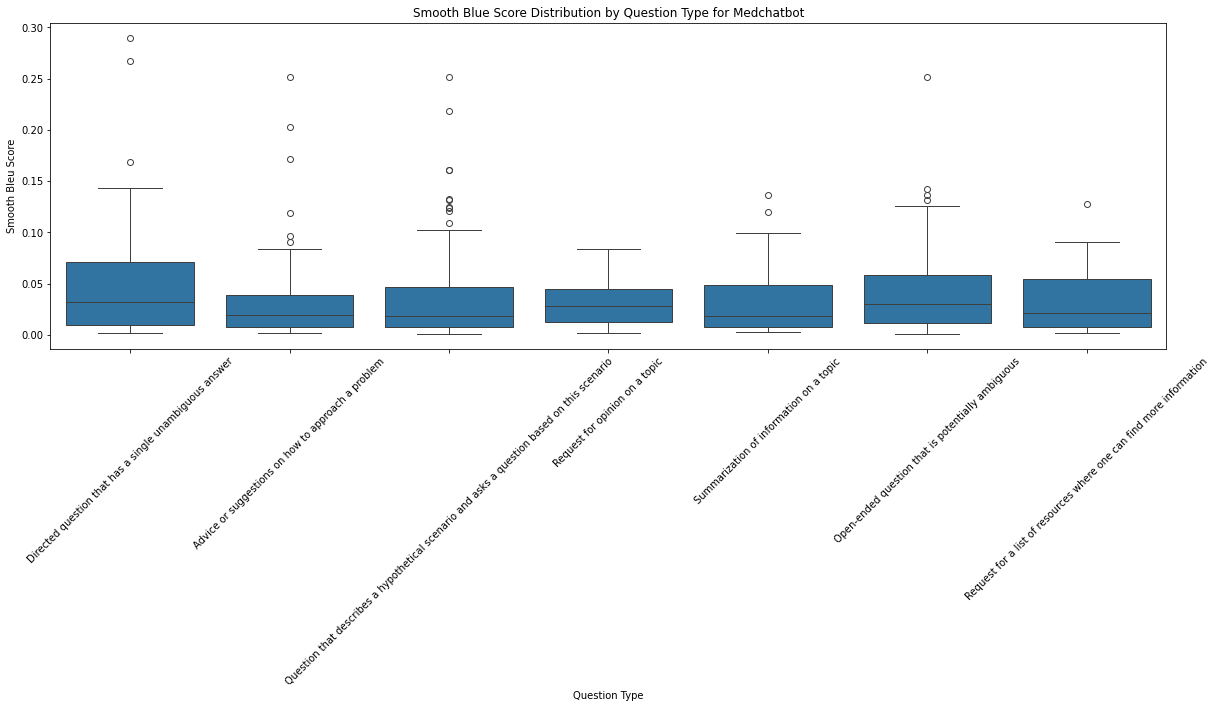

In [55]:
# Same thing for med chatbot
medchatbot_with_qtype_exploded_df = medchatbot_with_qtype.explode('question_types')

plt.figure(figsize=(20, 6))
sns.boxplot(x='question_types', y='Smooth_Bleu_Score', data=medchatbot_with_qtype_exploded_df)
plt.title('Smooth Blue Score Distribution by Question Type for Medchatbot')
plt.xlabel('Question Type')
plt.ylabel('Smooth Bleu Score')
plt.xticks(rotation=45)
plt.show()

### Specific field graphs



We need to condense the specific field because there is a lot of trivial overlap

In [56]:
set(biomstrl_with_qtype['specific_field'])

{'Aesthetic',
 'Ambulance ',
 'Audiologist',
 'Audiology',
 'Biochemistry',
 'Biomedical Research, Nursing',
 'Biomedical Science ',
 'Biomedical engineering. Main area of work is developing primary health care equipment.',
 'Biomedical technologist',
 'Cardiology',
 'Care home',
 'Care worker',
 'Casualty Nurse',
 'Chemistry in the clinical area',
 'Clinical Laboratory',
 'Clinical Psychologist',
 'Clinical Psychology',
 'Clinical Research',
 'Clinical pharmacology and pharmacovigilance',
 'Critical care',
 'Dementia ',
 'Dentistry',
 'Dermatology',
 'Dietician/ Nutritionist ',
 'Dispensery',
 'Doctor of Medicine',
 'Emergency Medicine',
 'Emergency Paediatrics',
 'Emergency Planning',
 'Family Medicine',
 'Family Medicine ',
 'Family medicine',
 'Family medicine ',
 'General',
 'General Medicine ',
 'General Physician',
 'General medical',
 'General medicine',
 'General medicine ',
 'General practitioner ',
 'Generalist physician',
 'Haematology',
 'Healthcare ',
 'I am a nursing and

In [59]:
# Clean specific fields because there is overlap 
category_map = {
    'Oncology': ['Oncology', 'Oncology Pharmacist', 'oncology'],
    'Pharmacy': ['Pharmacist', 'Pharmacy', 'Pharmacy field', 'pharmacist', 'Dispensery'],
    'Psychology/Psychiatry': ['Clinical Psychologist', 'Psychiatry', 'Psychology', 'Psychotherapy', 'psychiatrist', 'psychology'],
    'Nursing/Midwifery': ['Nursing', 'Midwifery', 'Casualty Nurse', 'Critical care', 'nurse ', 'registered nurse in trauma', 'midwifery'],
    'Medicine/Surgery': ['General medicine', 'General Medicine', 'General practitioner', 'Doctor of Medicine', 'Surgeon', 'Emergency Medicine', 'Internal medicine', 'internal medicine', 'Pediatrician', 'General Physician', 'General medical'],
    'Cardiology': ['Cardiology'],
    'Neurology': ['Neurology', 'Neuroscience researcher'],
    'Clinical Research': ['Clinical Research', 'Medical research, clinical studies', 'Research scientist'],
    'Dentistry': ['Dentistry', 'dentist'],
    'Biomedical Engineering/Science': ['Biomedical Science', 'Biomedical engineering. Main area of work is developing primary health care equipment.', 'Biomedical technologist', 'biomedical science'],
    'Allied Health': ['Audiologist', 'Audiology', 'Dietician/ Nutritionist', 'Occupational Therapy', 'Physiotherapy', 'Speech and Language Therapy'],
    'Radiology': ['Radiology'],
    'Public Health/Safety': ['Emergency Planning', 'Patient Safety', 'Occupational Health, Environment and Safety'],
    'Healthcare Support': ['Care worker', 'Support Work', 'social worker'],
    'Others': ['General', 'Healthcare', 'Pharmaceutical industry', 'Sales rep in medicines']
}

# Create a function to map each field to its broad category
def map_to_category(field):
    for category, keywords in category_map.items():
        if field in keywords:
            return category
    return 'Others'


In [ ]:

# Apply the mapping function to create a new column
biomstrl_with_qtype['broad_field'] = biomstrl_with_qtype['specific_field'].apply(map_to_category)

biomstrl_with_qtype.head()

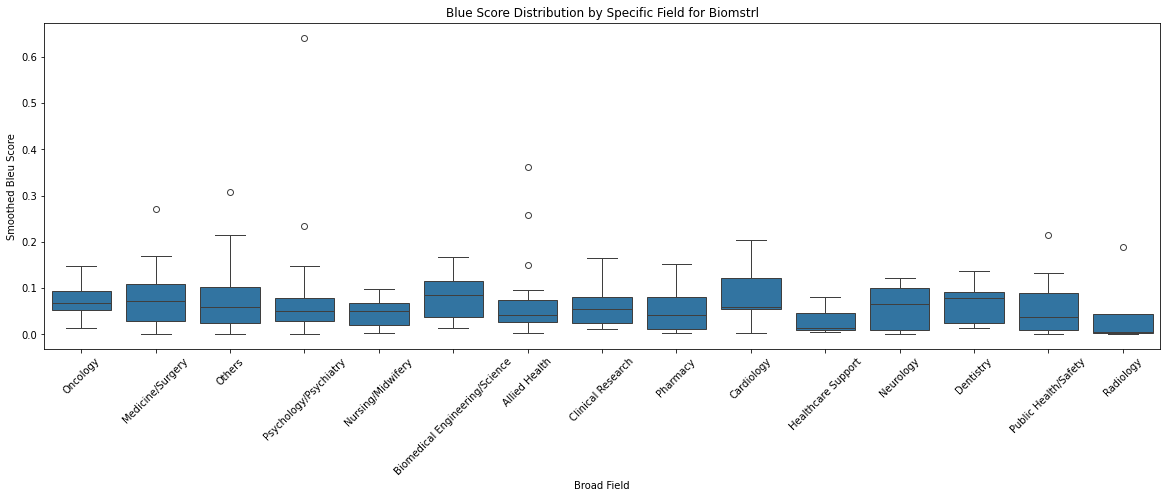

In [58]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='broad_field', y='Smooth_Bleu_Score', data=biomstrl_with_qtype)
plt.title('Blue Score Distribution by Specific Field for Biomstrl')
plt.xlabel('Broad Field')
plt.ylabel('Smoothed Bleu Score')
plt.xticks(rotation=45)
plt.show()

In [60]:

# Apply the mapping function to create a new column
medchatbot_with_qtype['broad_field'] = medchatbot_with_qtype['specific_field'].apply(map_to_category)

medchatbot_with_qtype.head()

,question,Smooth_Bleu_Score,question_types,specific_field,broad_field
0,What are signs and study findings that would i...,0.039175,[Directed question that has a single unambiguo...,Oncology,Oncology
1,A patient with a history of heart failure now ...,0.083652,[Advice or suggestions on how to approach a pr...,Oncology,Oncology
2,What does research currently say regarding the...,0.062602,[Summarization of information on a topic],Oncology,Oncology
3,A patient with Ewing sarcoma of the femur is d...,0.053922,[Directed question that has a single unambiguo...,Oncology,Oncology
4,In which cases would be considered appropiate ...,0.019201,[Open-ended question that is potentially ambig...,General Physician,Medicine/Surgery


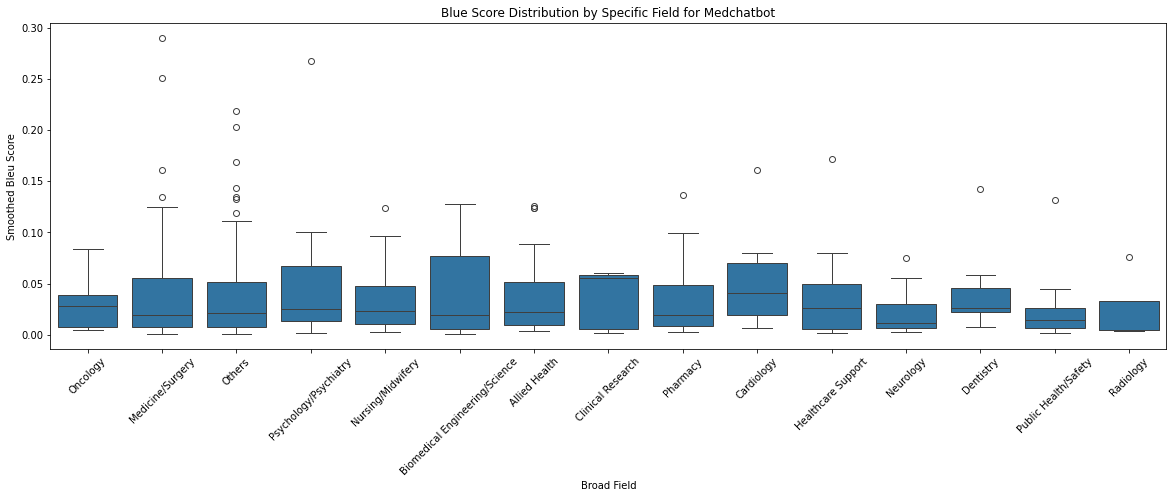

In [61]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='broad_field', y='Smooth_Bleu_Score', data=medchatbot_with_qtype)
plt.title('Blue Score Distribution by Specific Field for Medchatbot')
plt.xlabel('Broad Field')
plt.ylabel('Smoothed Bleu Score')
plt.xticks(rotation=45)
plt.show()